# Import

In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

import medmnist
from medmnist import INFO, Evaluator

# Task 1: Acquire the data

## load OrganAMNIST dataset from MedMNIST


In [2]:
# Config
data_flag = 'organamnist'
download = True

BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [3]:
# Temporary transformation to load data as tensors without normalization
temp_transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset with temporary transformation
train_dataset = DataClass(split='train', transform=temp_transform, download=download)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Calculate mean and std for the training dataset
mean = 0.0
std = 0.0

min_pixel = float('inf')
max_pixel = float('-inf')

for images, _ in train_loader:
    batch_samples = images.size(0)  # batch size (the last batch can have fewer samples)
    images = images.view(batch_samples, images.size(1), -1)  # reshape to [batch_size, channels, pixels]
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

    # Update min and max pixel values
    min_pixel = min(min_pixel, images.min().item())
    max_pixel = max(max_pixel, images.max().item())

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")
print(f"Min Pixel: {min_pixel}")
print(f"Max Pixel: {max_pixel}")

# Update the transformation with calculated mean and std
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Reload the datasets with the updated transformation
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz
Calculated mean: tensor([0.4680])
Calculated std: tensor([0.2472])
Min Pixel: 0.0
Max Pixel: 1.0
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz


In [4]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset OrganAMNIST of size 28 (organamnist)
    Number of datapoints: 34561
    Root location: C:\Users\kbzh\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 34561, 'val': 6491, 'test': 17778}
    Description: The OrganAMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Axial (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in axial views (planes). The images are resized into 1×28×28 to perform m

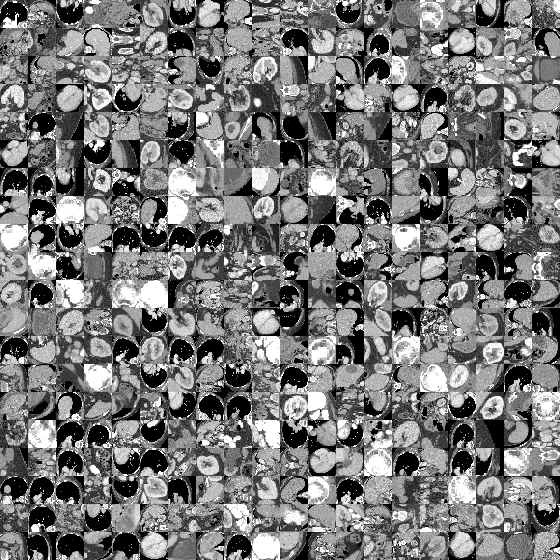

In [47]:
# vis: display imgs
train_dataset.montage(length=20)

In [48]:
# Label dictionary from the dataset information
label_dict = {
    '0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart',
    '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left',
    '8': 'lung-right', '9': 'pancreas', '10': 'spleen'
}

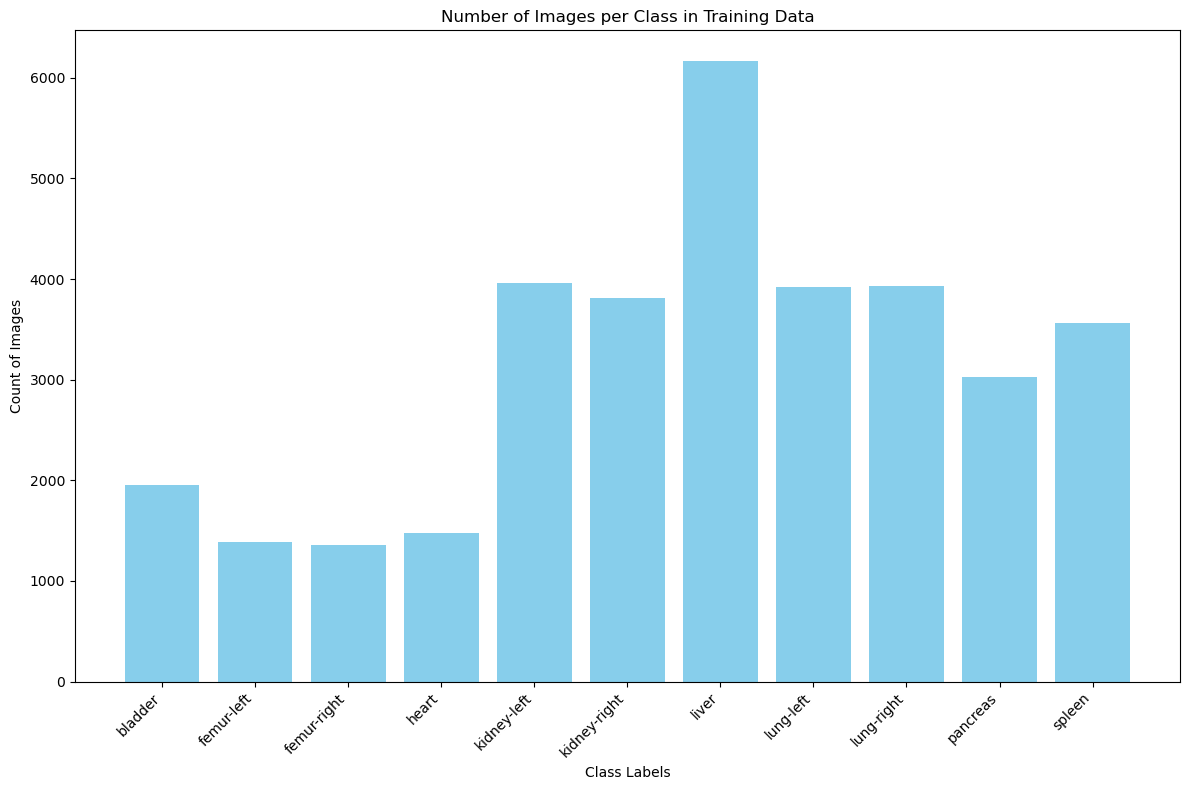

In [49]:
from collections import Counter

# Count the number of images per class in the training dataset
label_counts = Counter([int(lbl) for _, lbl in train_dataset])

# Get class names and their corresponding counts
class_names = [label_dict[str(label)] for label in sorted(label_counts.keys())]
counts = [label_counts[label] for label in sorted(label_counts.keys())]

# Plotting the bar chart
plt.figure(figsize=(12, 8))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Class Labels")
plt.ylabel("Count of Images")
plt.title("Number of Images per Class in Training Data")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Task 2: Implement a Multilayer Perceptron


In [5]:
class MLP:
    def __init__(self, activation='', hidden_layers=0, units=[], input_dim=1, output_dim=1, initialization='xavier', dropout_rate=0.0):
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.units = units
        self.input_dim = input_dim  
        self.output_dim = output_dim  
        self.weights = []
        self.biases = []
        self.dropout_rate = dropout_rate

        # Input layer to first hidden layer
        if self.hidden_layers > 0:
            self.weights.append(self.initialize_weights(input_dim, units[0], initialization))
            self.biases.append(np.zeros((1, units[0])))
        else:
            self.weights.append(self.initialize_weights(input_dim, output_dim, initialization))
            self.biases.append(np.zeros((1, output_dim)))

        # Hidden layers
        for i in range(1, hidden_layers):
            self.weights.append(self.initialize_weights(units[i-1], units[i], initialization))
            self.biases.append(np.zeros((1, units[i])))

        # Last hidden layer to output layer
        if self.hidden_layers > 0:
            self.weights.append(self.initialize_weights(units[-1], output_dim, initialization))
            self.biases.append(np.zeros((1, output_dim)))

    def initialize_weights(self, input_size, output_size, initialization):
        if initialization == 'zeros':
            return np.zeros((input_size, output_size))
        elif initialization == 'uniform':
            return np.random.uniform(-1, 1, (input_size, output_size))
        elif initialization == 'gaussian':
            return np.random.randn(input_size, output_size)
        elif initialization == 'xavier':
            return np.random.randn(input_size, output_size) / np.sqrt(input_size)
        elif initialization == 'kaiming':
            return np.random.randn(input_size, output_size) * np.sqrt(2. / input_size)
        else:
            raise ValueError("Invalid initialization method.")

    # Activation functions
    def relu(self, z):
        return np.maximum(0, z)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    def tanh(self, z):
        return np.tanh(z)

    def tanh_derivative(self, z):
        return 1 - np.tanh(z) ** 2
    
    def leaky_relu(self, z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)

    def leaky_relu_derivative(self, z, alpha=0.01):
        return np.where(z > 0, 1, alpha)

    def softmax(self, z):
        exps = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    # Helper methods to select activation functions
    def activation_forward(self, z):
        if self.activation == 'relu':
            return self.relu(z)
        elif self.activation == 'sigmoid':
            return self.sigmoid(z)
        elif self.activation == 'tanh':
            return self.tanh(z)
        elif self.activation == 'leaky_relu':
            return self.leaky_relu(z)
        else:
            raise ValueError("Invalid activation function.")

    def activation_backward(self, z):
        if self.activation == 'relu':
            return self.relu_derivative(z)
        elif self.activation == 'sigmoid':
            return self.sigmoid_derivative(z)
        elif self.activation == 'tanh':
            return self.tanh_derivative(z)
        elif self.activation == 'leaky_relu':
            return self.leaky_relu_derivative(z)
        else:
            raise ValueError("Invalid activation function.")

    def output_activation_forward(self, z):
        return self.softmax(z)
        
    def one_hot_encode(self, y):
        num_classes = self.output_dim  
        encoded = np.zeros((y.shape[0], num_classes))
        for i, val in enumerate(y):
            encoded[i, val] = 1
        return encoded

    def compute_loss(self, X, y_true, reg='', lambda_=0.0):
        y_pred = self.predict(X)
        epsilon = 1e-8
        y_true_encoded = self.one_hot_encode(y_true)

        loss = -np.mean(np.sum(y_true_encoded * np.log(y_pred + epsilon), axis=1))
        
        # Add regularization
        if reg == 'l1':
            regularization_term = lambda_ * sum(np.abs(w).sum() for w in self.weights)
        elif reg == 'l2':
            regularization_term = lambda_ * sum((w ** 2).sum() for w in self.weights)
        else:
            regularization_term = 0  # No regularization

        return loss + regularization_term

    def fit(self, X, y, learning_rate, epochs, batch_size, reg='', lambda_=0.0):
        losses = []
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]

            # Mini-batch gradient descent
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                # Forward pass
                a = [X_batch]
                z = []
                for idx, (w, b) in enumerate(zip(self.weights, self.biases)):
                    z_current = np.dot(a[-1], w) + b
                    z.append(z_current)
                    if idx != len(self.weights)-1:
                        a.append(self.activation_forward(z_current))
                    else:
                        a.append(self.softmax(z_current))
                # Backward pass
                y_batch_encoded = self.one_hot_encode(y_batch)
                dz = [a[-1] - y_batch_encoded]
                for j in range(self.hidden_layers, 0, -1):
                    da = np.dot(dz[-1], self.weights[j].T)
                    dz.append(da * self.activation_backward(z[j-1]))
                dz.reverse()

                # Update weights and biases
                for j in range(self.hidden_layers + 1):
                    if reg == 'l2':
                        self.weights[j] -= learning_rate * (np.dot(a[j].T, dz[j]) / batch_size + lambda_ * self.weights[j])
                    elif reg == 'l1':
                        self.weights[j] -= learning_rate * (np.dot(a[j].T, dz[j]) / batch_size + lambda_ * np.sign(self.weights[j]))
                    else:
                        self.weights[j] -= learning_rate * np.dot(a[j].T, dz[j]) / batch_size
                    self.biases[j] -= learning_rate * np.sum(dz[j], axis=0, keepdims=True) / batch_size
            epoch_loss = self.compute_loss(X, y, reg=reg, lambda_=lambda_)
            losses.append(epoch_loss)
        return losses

    def fit_with_time(self, X, y, learning_rate, epochs, batch_size, reg='', lambda_=0.0):
        losses = []
        epoch_times = []
        for epoch in range(epochs):
            start_time = time.time()
            # Shuffle the data at the beginning of each epoch
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]

            # Mini-batch gradient descent
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                # Forward pass
                a = [X_batch]
                z = []
                for idx, (w, b) in enumerate(zip(self.weights, self.biases)):
                    z_current = np.dot(a[-1], w) + b
                    z.append(z_current)
                    if idx != len(self.weights)-1:
                        a.append(self.activation_forward(z_current))
                    else:
                        a.append(self.softmax(z_current))
                # Backward pass
                y_batch_encoded = self.one_hot_encode(y_batch)
                dz = [a[-1] - y_batch_encoded]
                for j in range(self.hidden_layers, 0, -1):
                    da = np.dot(dz[-1], self.weights[j].T)
                    dz.append(da * self.activation_backward(z[j-1]))
                dz.reverse()

                # Update weights and biases
                for j in range(self.hidden_layers + 1):
                    if reg == 'l2':
                        self.weights[j] -= learning_rate * (np.dot(a[j].T, dz[j]) / batch_size + lambda_ * self.weights[j])
                    elif reg == 'l1':
                        self.weights[j] -= learning_rate * (np.dot(a[j].T, dz[j]) / batch_size + lambda_ * np.sign(self.weights[j]))
                    else:
                        self.weights[j] -= learning_rate * np.dot(a[j].T, dz[j]) / batch_size
                    self.biases[j] -= learning_rate * np.sum(dz[j], axis=0, keepdims=True) / batch_size
            epoch_loss = self.compute_loss(X, y, reg=reg, lambda_=lambda_)
            losses.append(epoch_loss)

            end_time = time.time()
            epoch_duration = end_time - start_time
            epoch_times.append(epoch_duration)
            if epoch%10==0:
                print(f'Epoch {epoch} done')
        return losses, epoch_times
    
    def predict(self, X):
        a = X
        for idx, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(a, w) + b
            if idx != len(self.weights)-1:
                a = self.activation_forward(z)
            else:
                a = self.softmax(z)
        return a

    def predict_class(self, X):
        probabilities = self.predict(X)
        return np.argmax(probabilities, axis=1)


In [6]:
def evaluate_acc(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Task 3: Run experiments

In [7]:
# change dataloader to numpy flattened arrays
def dataloader_to_numpy(dataloader):
    X_list = []
    y_list = []

    # Iterate over the entire dataloader
    for img, lbl in tqdm(dataloader):
        # Flatten each batch of images and convert to numpy arrays
        X_batch = img.view(img.size(0), -1).numpy()  # [batch_size, 784]
        y_batch = lbl.numpy()  # [batch_size]

        # Append each batch to the lists
        X_list.append(X_batch)
        y_list.append(y_batch)

    # Concatenate all batches to form the full dataset
    X = np.concatenate(X_list, axis=0)  # [total_samples, 784]
    y = np.concatenate(y_list, axis=0)  # [total_samples]

    return X, y

In [8]:
# Convert train and test data to numpy
X_train, y_train = dataloader_to_numpy(train_loader)
X_test, y_test = dataloader_to_numpy(test_loader)
X_val, y_val = dataloader_to_numpy(val_loader)

100%|██████████| 26/26 [00:00<00:00, 26.86it/s]


# Task 3: Run the experiments and report

### Choice for Initialization


Training model with zeros initialization...

Training model with uniform initialization...

Training model with gaussian initialization...

Training model with xavier initialization...

Training model with kaiming initialization...


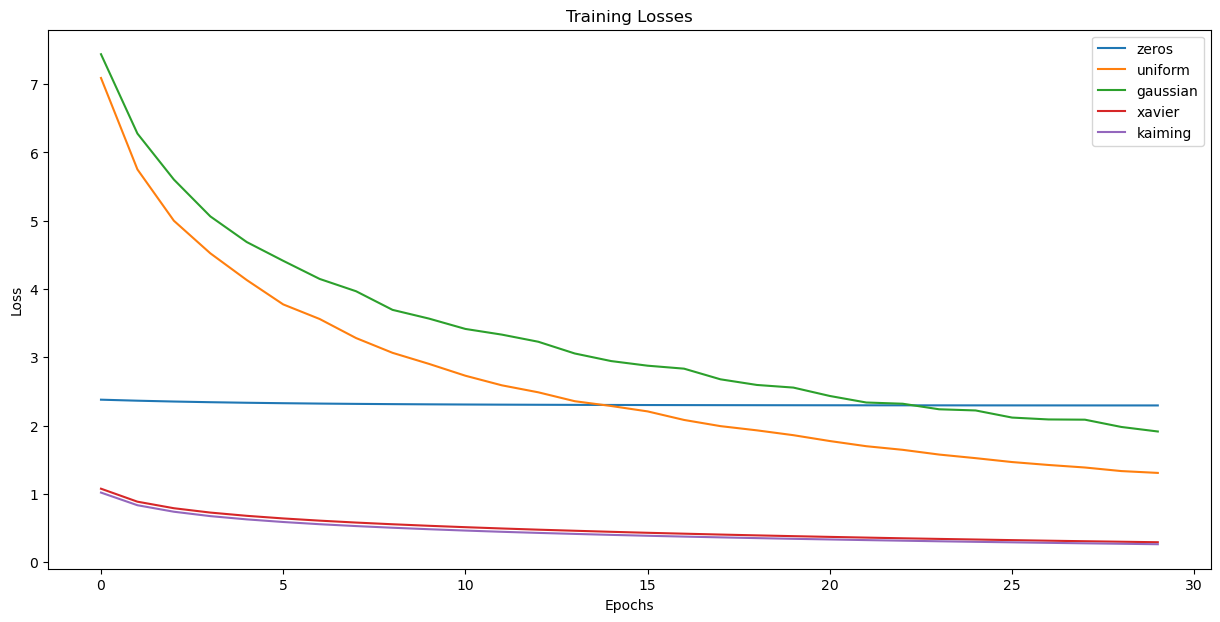

In [10]:
# initialize the model
input_dim = X_train.shape[1]
output_dim = np.unique(y_train).size

# Create models with different weight initializations
init_methods = ["zeros", "uniform", "gaussian", "xavier", "kaiming"]
models = {method: MLP(activation="relu", hidden_layers=1, units=[256], input_dim=input_dim, output_dim=output_dim, initialization=method) for method in init_methods}

# Training parameters
learning_rate = 0.001
epochs = 30  
batch_size = 32  

# Train the models
training_curves = {}
for method, model in models.items():
    print(f"\nTraining model with {method} initialization...")
    losses = model.fit(X_train, y_train, learning_rate, epochs, batch_size)
    training_curves[method] = losses

# Plot training curves
plt.figure(figsize=(15,7))
for method, losses in training_curves.items():
    plt.plot(losses, label=method)
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Evaluate models
val_accuracies = {}
for method, model in models.items():
    y_pred = model.predict_class(X_val)
    accuracy = evaluate_acc(y_val.flatten(), y_pred)
    val_accuracies[method] = accuracy
    print(f"Validation accuracy of model with {method} initialization: {accuracy:.4f}")

Validation accuracy of model with zeros initialization: 0.1591
Validation accuracy of model with uniform initialization: 0.8107
Validation accuracy of model with gaussian initialization: 0.8060
Validation accuracy of model with xavier initialization: 0.9056
Validation accuracy of model with kaiming initialization: 0.8976


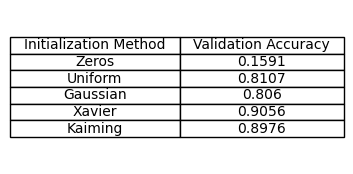

In [2]:
# Data for the table
data = {
    "Initialization Method": [
        "Zeros",
        "Uniform",
        "Gaussian",
        "Xavier",
        "Kaiming"
    ],
    "Validation Accuracy": [
        0.1591,
        0.8107,
        0.8060,
        0.9056,
        0.8976
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Adjusting padding around the table
fig, ax = plt.subplots(figsize=(4, 2))  # Adjust the figure size to reduce padding
ax.axis('off')  # Turn off the axes

# Add a table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.show()



In [17]:
model = MLP(activation="relu", hidden_layers=2, units=[256,256], input_dim=input_dim, output_dim=output_dim, initialization='xavier')

# Training parameters
batch_size = 32  

# Train the models
training_curves = {}
val_accuracies = {}

for learning_rate in [0.1, 0.01, 0.001]:
    for epoch in [10, 20,30,40,50,60]:
        print(f"\nTraining model with alpha={learning_rate}, epoch={epoch}...")
        losses = model.fit(X_train, y_train, learning_rate, epoch, batch_size)
        training_curves[f'({learning_rate},{epoch})']= losses
        # Evaluate models
        y_pred = model.predict_class(X_val)
        accuracy = evaluate_acc(y_val.flatten(), y_pred)
        val_accuracies[f'({learning_rate},{epoch})'] = accuracy
        print(f"Validation accuracy of model with learning rate {learning_rate} and epoch: {epoch}: {accuracy:.4f}")
        if epoch!=10 and accuracy <= val_accuracies[f'({learning_rate},{epoch-10})']:
            print('Overfitting--next param')
            break


Training model with alpha=0.1, epoch=10...
Validation accuracy of model with learning rate 0.1 and epoch: 10: 0.9162

Training model with alpha=0.1, epoch=20...
Validation accuracy of model with learning rate 0.1 and epoch: 20: 0.9128
Overfitting--next param

Training model with alpha=0.01, epoch=10...
Validation accuracy of model with learning rate 0.01 and epoch: 10: 0.9126

Training model with alpha=0.01, epoch=20...
Validation accuracy of model with learning rate 0.01 and epoch: 20: 0.9125
Overfitting--next param

Training model with alpha=0.001, epoch=10...
Validation accuracy of model with learning rate 0.001 and epoch: 10: 0.9125

Training model with alpha=0.001, epoch=20...
Validation accuracy of model with learning rate 0.001 and epoch: 20: 0.9125
Overfitting--next param


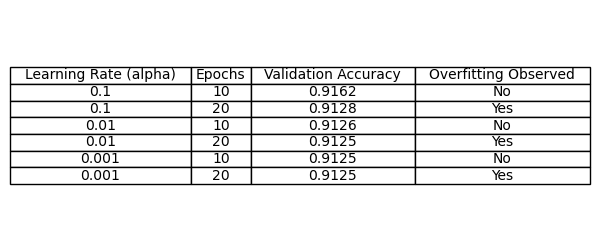

In [3]:
# Data for the table
data = {
    "Learning Rate (alpha)": [0.1, 0.1, 0.01, 0.01, 0.001, 0.001],
    "Epochs": [10, 20, 10, 20, 10, 20],
    "Validation Accuracy": [0.9162, 0.9128, 0.9126, 0.9125, 0.9125, 0.9125],
    "Overfitting Observed": ["No", "Yes", "No", "Yes", "No", "Yes"]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the table plot
fig, ax = plt.subplots(figsize=(7, 3))
ax.axis('off')  # Turn off the axes

# Add a table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.show()


## 1. Three MLP model:
(1) an MLP with no hidden layers, i.e., it directly maps the inputs
to outputs, 

(2) an MLP with a single hidden layer having 256 units and ReLU activations, 

(3) an MLP with 2
hidden layers each having 256 units with ReLU activations.

In [18]:
# initialize the model
input_dim = X_train.shape[1]
output_dim = np.unique(y_train).size

models = {
    "no_hidden": MLP(activation="relu", hidden_layers=0, units=[], input_dim=input_dim, output_dim=output_dim, initialization="xavier"),
    
    "single_hidden": MLP(activation="relu", hidden_layers=1, units=[256], input_dim=input_dim, output_dim=output_dim, initialization="xavier"),
    
    "two_hidden": MLP(activation="relu", hidden_layers=2, units=[256, 256], input_dim=input_dim, output_dim=output_dim, initialization="xavier")
}

# training parameters
learning_rate = 0.1
epochs = 10 
batch_size = 32  

training_curves = {}
# train
for struc, model in models.items():
    print(f"\nTraining model with {struc} structure...")
    losses = model.fit(X_train, y_train, learning_rate, epochs, batch_size)
    training_curves[struc] = losses



Training model with no_hidden structure...

Training model with single_hidden structure...

Training model with two_hidden structure...


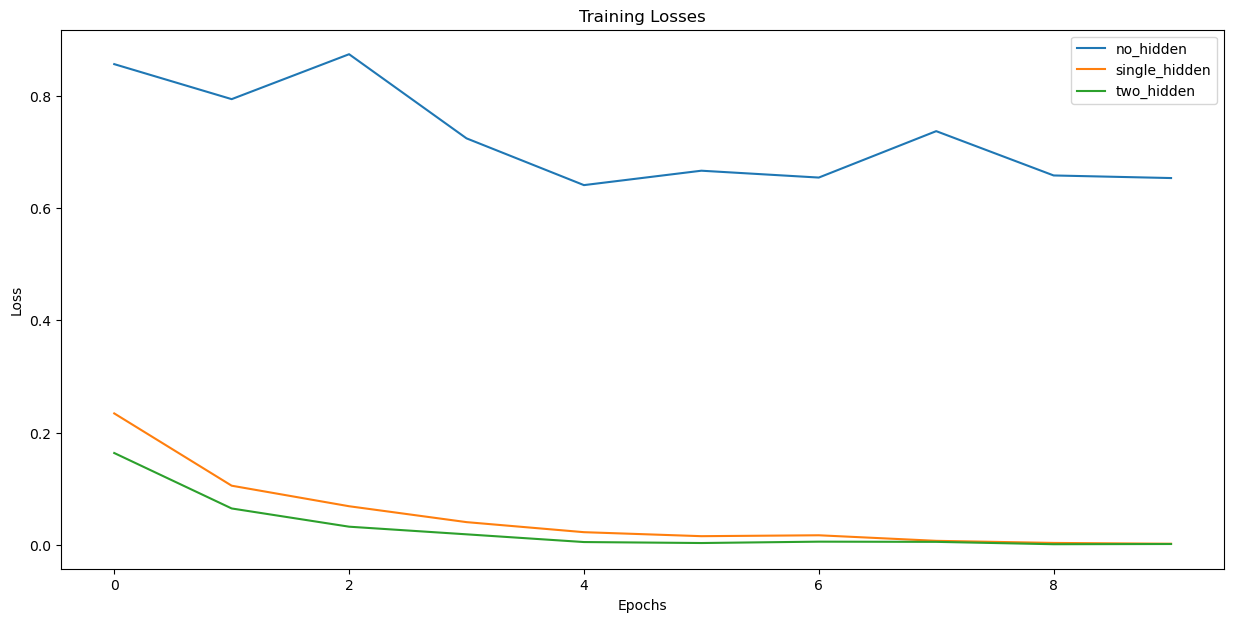

In [ ]:
# loss curves
plt.figure(figsize=(15,7))
for method, losses in training_curves.items():
    plt.plot(losses, label=method)
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Evaluate models
test_accuracies = {}
for struc, model in models.items():
    y_pred = model.predict_class(X_test)
    accuracy = evaluate_acc(y_test.flatten(), y_pred)
    test_accuracies[struc] = accuracy
    print(f"Test accuracy of model with {struc} structure: {accuracy:.4f}")

Test accuracy of model with no_hidden structure: 0.5541
Test accuracy of model with single_hidden structure: 0.7310
Test accuracy of model with two_hidden structure: 0.7564


## 2. Create two different copies of MLP in which the activations are now tanh and Leaky-ReLU

In [ ]:
# fit model
models = {activation: MLP(activation=activation, hidden_layers=2, units=[256, 256],input_dim=input_dim, output_dim=output_dim, initialization='xavier') for activation in ['tanh','leaky_relu']}

for activation, model in models.items():
    print(f"\nTraining model with {activation} activation...")
    _ = model.fit(X_train, y_train, learning_rate, epochs, batch_size)



Training model with tanh activation...

Training model with leaky_relu activation...


In [ ]:
# Evaluate models
test_accuracies2 = {}
for activation, model in models.items():
    y_pred = model.predict_class(X_test)
    accuracy = evaluate_acc(y_test.flatten(), y_pred)
    test_accuracies2[activation] = accuracy
    print(f"Test accuracy of model with {activation} activation: {accuracy:.4f}")

Test accuracy of model with tanh activation: 0.7276
Test accuracy of model with leaky_relu activation: 0.7575


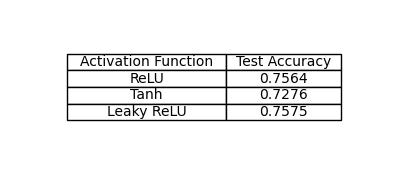

In [5]:
# Data for the table
data = {
    "Activation Function": ["ReLU","Tanh", "Leaky ReLU"],
    "Test Accuracy": [0.7564, 0.7276, 0.7575]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the table plot
fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('off')  # Turn off the axes

# Add a table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.show()

## 3. L1 and L2 regularization with MLP, 2 hidden layers each having 256 units with ReLU

In [ ]:
# hyper param tune
model = MLP(activation="relu", hidden_layers=2, units=[256,256], input_dim=input_dim, output_dim=output_dim, initialization='xavier')

# Training parameters
batch_size = 32  

# Train the models
# training_curves = {}
val_accuracies = {}
for reg in  ['l2','l1']:
    print(f"Regularization: {reg}--------------")
    for learning_rate in [0.1, 0.01, 0.001]:
        for epoch in [10,20,30,40,50,60]:
            print(f"\nTraining model with alpha={learning_rate}, epoch={epoch}...")
            _ = model.fit(X_train, y_train, learning_rate, epoch, batch_size, reg=reg, lambda_=0.1)
            # Evaluate models
            y_pred = model.predict_class(X_val)
            accuracy = evaluate_acc(y_val.flatten(), y_pred)
            val_accuracies[f'({learning_rate},{epoch})'] = accuracy
            print(f"Validation accuracy of model with learning rate {learning_rate} and epoch: {epoch}: {accuracy:.4f}")
            if epoch!=10 and accuracy <= val_accuracies[f'({learning_rate},{epoch-10})']:
                print('Overfitting--next param')
                break
    print('-------------------')

Regularization: l2--------------

Training model with alpha=0.1, epoch=10...
Validation accuracy of model with learning rate 0.1 and epoch: 10: 0.8170

Training model with alpha=0.1, epoch=20...
Validation accuracy of model with learning rate 0.1 and epoch: 20: 0.7413
Overfitting--next param

Training model with alpha=0.01, epoch=10...
Validation accuracy of model with learning rate 0.01 and epoch: 10: 0.8458

Training model with alpha=0.01, epoch=20...
Validation accuracy of model with learning rate 0.01 and epoch: 20: 0.8516

Training model with alpha=0.01, epoch=30...
Validation accuracy of model with learning rate 0.01 and epoch: 30: 0.8580

Training model with alpha=0.01, epoch=40...
Validation accuracy of model with learning rate 0.01 and epoch: 40: 0.8607

Training model with alpha=0.01, epoch=50...
Validation accuracy of model with learning rate 0.01 and epoch: 50: 0.8483
Overfitting--next param

Training model with alpha=0.001, epoch=10...
Validation accuracy of model with lea

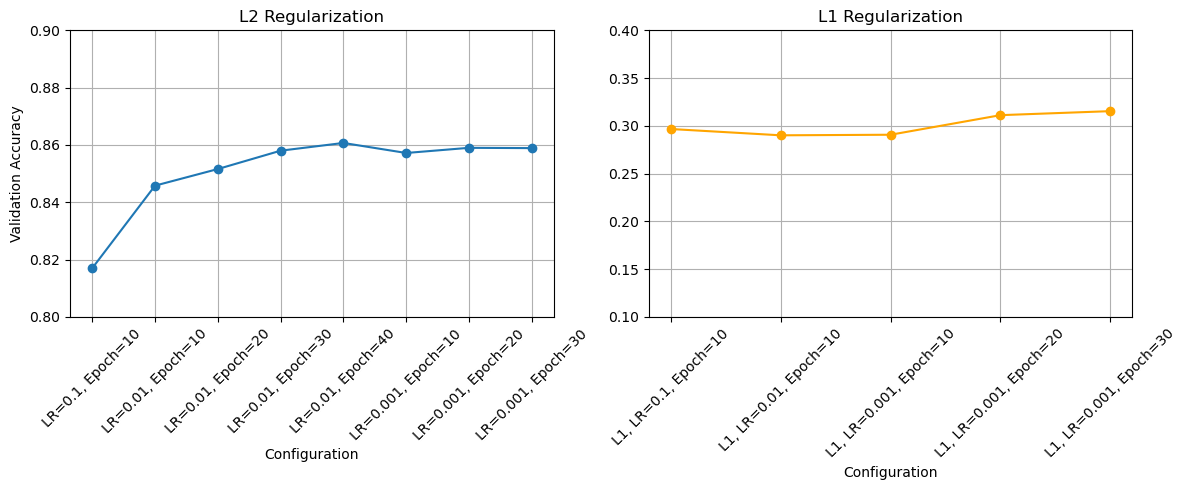

In [10]:
# Updated data for L2 regularization (non-overfitting configurations)
l2_data_full = {
    "Configuration": [
        "LR=0.1, Epoch=10",
        "LR=0.01, Epoch=10",
        "LR=0.01, Epoch=20",
        "LR=0.01, Epoch=30",
        "LR=0.01, Epoch=40",
        "LR=0.001, Epoch=10",
        "LR=0.001, Epoch=20",
        "LR=0.001, Epoch=30"
    ],
    "Validation Accuracy": [0.8170, 0.8458, 0.8516, 0.8580, 0.8607, 0.8572, 0.8590, 0.8589]
}

# Updated data for L1 regularization (non-overfitting configurations)
l1_data_full = {
    "Configuration": [
        "L1, LR=0.1, Epoch=10",
        "L1, LR=0.01, Epoch=10",
        "L1, LR=0.001, Epoch=10",
        "L1, LR=0.001, Epoch=20",
        "L1, LR=0.001, Epoch=30"
    ],
    "Validation Accuracy": [0.2967, 0.2901, 0.2907, 0.3112, 0.3154]
}

# Plot for L2 regularization with adjusted y-axis range
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# L2 Regularization plot
axes[0].plot(l2_data_full["Configuration"], l2_data_full["Validation Accuracy"], marker='o', label="L2")
axes[0].set_title("L2 Regularization")
axes[0].set_xlabel("Configuration")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_ylim(0.8, 0.9)  # Adjust y-axis range for L2
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)


# L1 Regularization plot
axes[1].plot(l1_data_full["Configuration"], l1_data_full["Validation Accuracy"], marker='o', color='orange', label="L1")
axes[1].set_title("L1 Regularization")
axes[1].set_xlabel("Configuration")
axes[1].set_ylim(0.1, 0.4)  # Adjust y-axis range for L1
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)


# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
# fit model and accuracy
model = MLP(activation='relu', hidden_layers=2, units=[256, 256], input_dim=input_dim, output_dim=output_dim, initialization='xavier')
test_accuracies3 = {}
for reg in  ['l2','l1']:
    if reg == 'l2':
        learning_rate = 0.01 
        epochs = 40
    else:
        learning_rate = 0.001 
        epochs = 30

    _ = model.fit(X_train, y_train, learning_rate, epochs, batch_size, reg=reg, lambda_=0.1)
    y_pred = model.predict_class(X_test)
    accuracy = evaluate_acc(y_test.flatten(), y_pred)
    test_accuracies3[reg] = accuracy
    print(f"Test accuracy of model with {reg} regularization: {accuracy:.4f}")

Test accuracy of model with l2 regularization: 0.6311
Test accuracy of model with l1 regularization: 0.1848


## 4. Effect of training with unnormalized images, MLP with 2 hidden layers each having 256 units with ReLU activations


In [39]:
# load original data
unnormalized_transform = transforms.Compose([transforms.ToTensor()])

train_dataset_unnormalized = DataClass(split='train', transform=unnormalized_transform, download=download)
train_loader_unnormalized = DataLoader(dataset=train_dataset_unnormalized, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_unnormalized = DataClass(split='test', transform=unnormalized_transform, download=download)
test_loader_unnormalized = DataLoader(dataset=test_dataset_unnormalized, batch_size=2*BATCH_SIZE, shuffle=False)

val_dataset_unnormalized = DataClass(split='val', transform=unnormalized_transform, download=download)
val_loader_unnormalized = DataLoader(dataset=val_dataset_unnormalized, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist.npz


In [40]:
# Convert train and test data to numpy
X_train_unnormalized, y_train_unnormalized = dataloader_to_numpy(train_loader_unnormalized)
X_test_unnormalized, y_test_unnormalized = dataloader_to_numpy(test_loader_unnormalized)

  0%|          | 0/271 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:01<00:00, 43.32it/s]


In [41]:
# fit model and accuracy
learning_rate = 0.1
epochs = 10
model = MLP(activation='relu', hidden_layers=2, units=[256, 256], input_dim=input_dim, output_dim=output_dim, initialization='xavier')

_ = model.fit(X_train_unnormalized, y_train_unnormalized, learning_rate, epochs, batch_size)
y_pred = model.predict_class(X_test_unnormalized)
accuracy = evaluate_acc(y_test_unnormalized.flatten(), y_pred)
print(f"Test accuracy of model with unnormalized data: {accuracy:.4f}")

Test accuracy of model with unnormalized data: 0.7479


## 5. Effect on epochs and compute time with the 128 pixels version of OrganAMNIST

In [14]:
epoch_times = {}
epoch_times['28'] = {}

In [16]:
model = MLP(activation='relu', hidden_layers=2, units=[256, 256], input_dim=input_dim, output_dim=output_dim, initialization='xavier')

training_curves4 = {}
test_accuracies4 = {}
for reg in  ['l2','l1']:
    if reg == 'l2':
        learning_rate = 0.01 
        epochs = 40
    else:
        learning_rate = 0.001 
        epochs = 30
        
    losses, epoch_times['28'][reg] = model.fit_with_time(X_train, y_train, learning_rate, epochs, batch_size, reg=reg, lambda_=0.1)
    training_curves4[reg] = losses
    y_pred = model.predict_class(X_test)
    accuracy = evaluate_acc(y_test.flatten(), y_pred)
    test_accuracies4[reg] = accuracy
    print(f"Test accuracy of model with {reg} regularization, 28*28 data: {accuracy:.4f}")

Epoch 0 done
Epoch 10 done
Epoch 20 done
Epoch 30 done
Test accuracy of model with l2 regularization, 28*28 data: 0.6320
Epoch 0 done
Epoch 10 done
Epoch 20 done
Test accuracy of model with l1 regularization, 28*28 data: 0.1848


### load 128 pixel data

In [13]:
# Temporary transformation to load data as tensors without normalization
temp_transform = transforms.Compose([transforms.ToTensor()])
size = 128
# Load the dataset with temporary transformation
train_dataset = DataClass(split='train', transform=temp_transform, download=download, size=size)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Calculate mean and std for the training dataset
mean128 = 0.0
std128 = 0.0

min_pixel = float('inf')
max_pixel = float('-inf')

for images, _ in train_loader:
    batch_samples = images.size(0)  # batch size (the last batch can have fewer samples)
    images = images.view(batch_samples, images.size(1), -1)  # reshape to [batch_size, channels, pixels]
    mean128 += images.mean(2).sum(0)
    std128 += images.std(2).sum(0)

    # Update min and max pixel values
    min_pixel = min(min_pixel, images.min().item())
    max_pixel = max(max_pixel, images.max().item())

mean128 /= len(train_loader.dataset)
std128 /= len(train_loader.dataset)

print(f"Calculated mean: {mean128}")
print(f"Calculated std: {std128}")
print(f"Min Pixel: {min_pixel}")
print(f"Max Pixel: {max_pixel}")

# Update the transformation with calculated mean and std
data_transform128 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean128.tolist(), std=std128.tolist())
])

# Reload the datasets with the updated transformation
train_dataset128 = DataClass(split='train', transform=data_transform128, download=download, size=size)
test_dataset128 = DataClass(split='test', transform=data_transform128, download=download, size=size)
val_dataset128 = DataClass(split='val', transform=data_transform128, download=download, size=size)

# Create DataLoaders
train_loader128 = DataLoader(dataset=train_dataset128, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval128 = DataLoader(dataset=train_dataset128, batch_size=2*BATCH_SIZE, shuffle=False)
val_loader128 = DataLoader(dataset=val_dataset128, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader128 = DataLoader(dataset=test_dataset128, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist_128.npz
Calculated mean: tensor([0.4680])
Calculated std: tensor([0.2349])
Min Pixel: 0.0
Max Pixel: 1.0
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist_128.npz
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist_128.npz
Using downloaded and verified file: C:\Users\kbzh\.medmnist\organamnist_128.npz


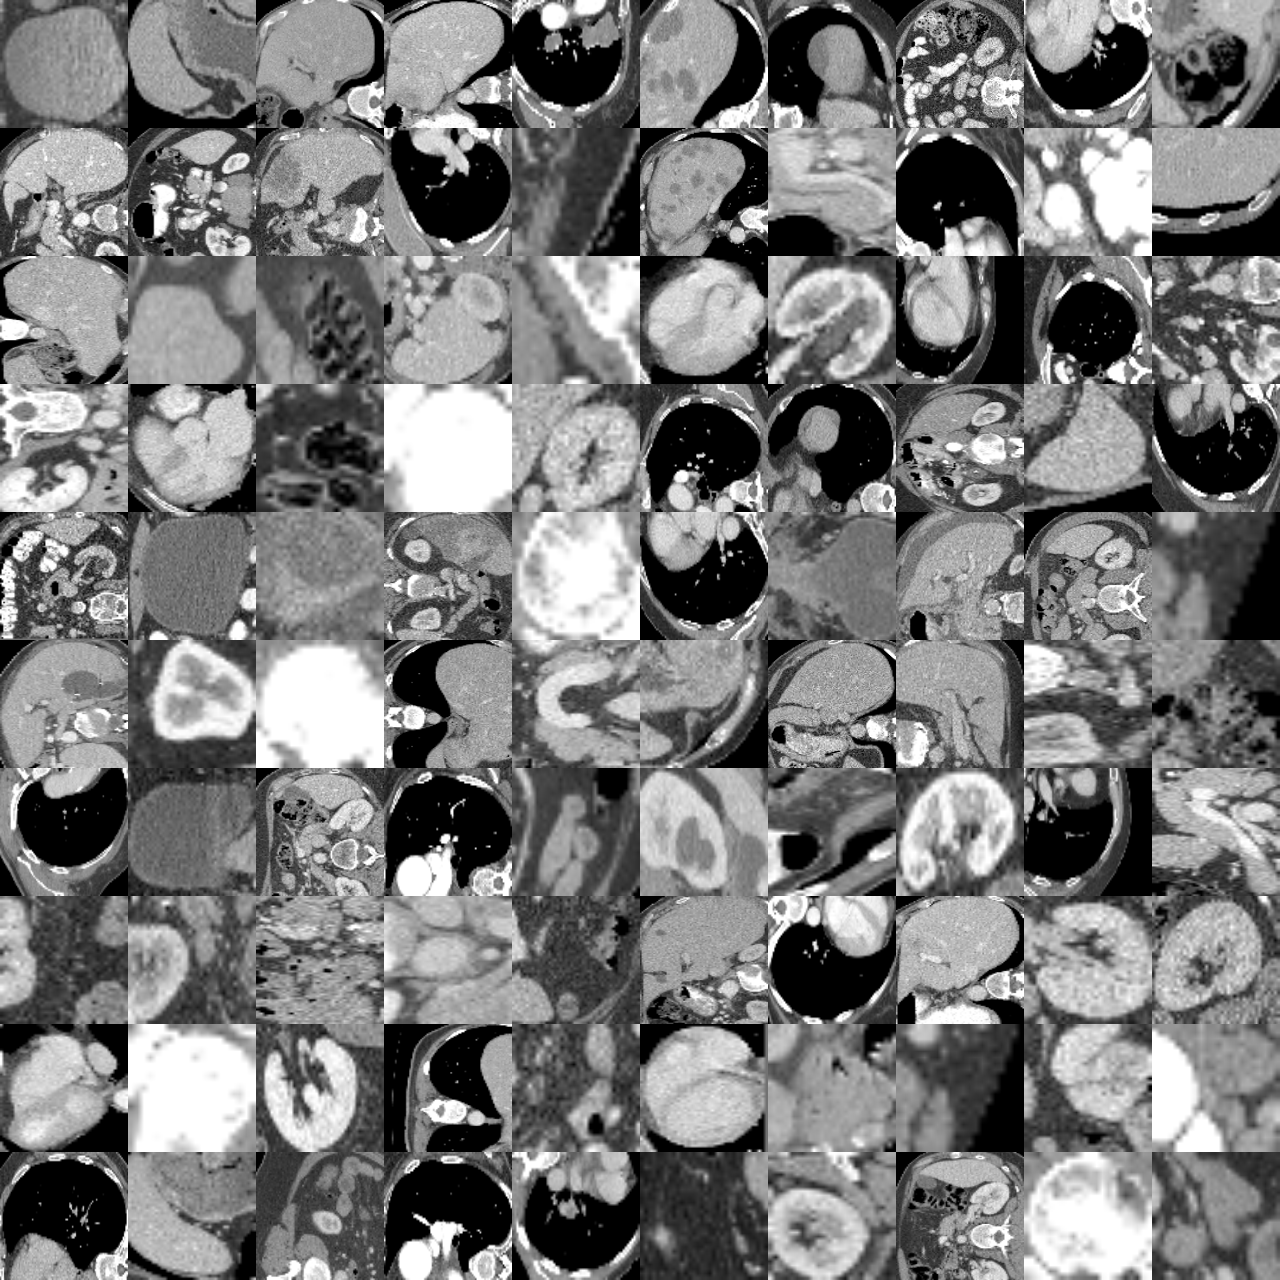

In [ ]:
# vis: display imgs
display(train_dataset128.montage(length=10))

In [18]:
# Convert train and test data to numpy
X_train128, y_train128 = dataloader_to_numpy(train_loader128)
X_test128, y_test128 = dataloader_to_numpy(test_loader128)
X_val128, y_val128 = dataloader_to_numpy(val_loader128)

100%|██████████| 26/26 [00:02<00:00, 12.49it/s]


In [19]:
# tuning hyper param
input_dim128 = X_train128.shape[1]
output_dim128 = np.unique(y_train128).size
model = MLP(activation="relu", hidden_layers=2, units=[256,256], input_dim=input_dim128, output_dim=output_dim128, initialization='xavier')

# Training parameters
batch_size = 32  
val_accuracies = {}
# Train the models
for reg in  ['l2','l1']:
    print(f"Regularization: {reg}--------------")
    for epoch in [30,40,50,60]:
        print(f"\nTraining model with alpha={0.001}, epoch={epoch}...")
        _ = model.fit(X_train128, y_train128, 0.001, epoch, batch_size, reg=reg, lambda_=0.1)
        # Evaluate models
        y_pred = model.predict_class(X_val128)
        accuracy = evaluate_acc(y_val128.flatten(), y_pred)
        val_accuracies[f'{epoch}'] = accuracy
        print(f"Validation accuracy of model with learning rate {0.001} and epoch: {epoch}: {accuracy:.4f}")
        if epoch!=30 and accuracy <= val_accuracies[f'{epoch-10}']:
            print('Overfitting--next param')
            break
    print('-------------------')

Regularization: l2--------------

Training model with alpha=0.001, epoch=30...
Validation accuracy of model with learning rate 0.001 and epoch: 30: 0.9190

Training model with alpha=0.001, epoch=40...
Validation accuracy of model with learning rate 0.001 and epoch: 40: 0.9228

Training model with alpha=0.001, epoch=50...
Validation accuracy of model with learning rate 0.001 and epoch: 50: 0.9268

Training model with alpha=0.001, epoch=60...
Validation accuracy of model with learning rate 0.001 and epoch: 60: 0.9311
-------------------
Regularization: l1--------------

Training model with alpha=0.001, epoch=30...
Validation accuracy of model with learning rate 0.001 and epoch: 30: 0.1591

Training model with alpha=0.001, epoch=40...
Validation accuracy of model with learning rate 0.001 and epoch: 40: 0.1591
Overfitting--next param
-------------------


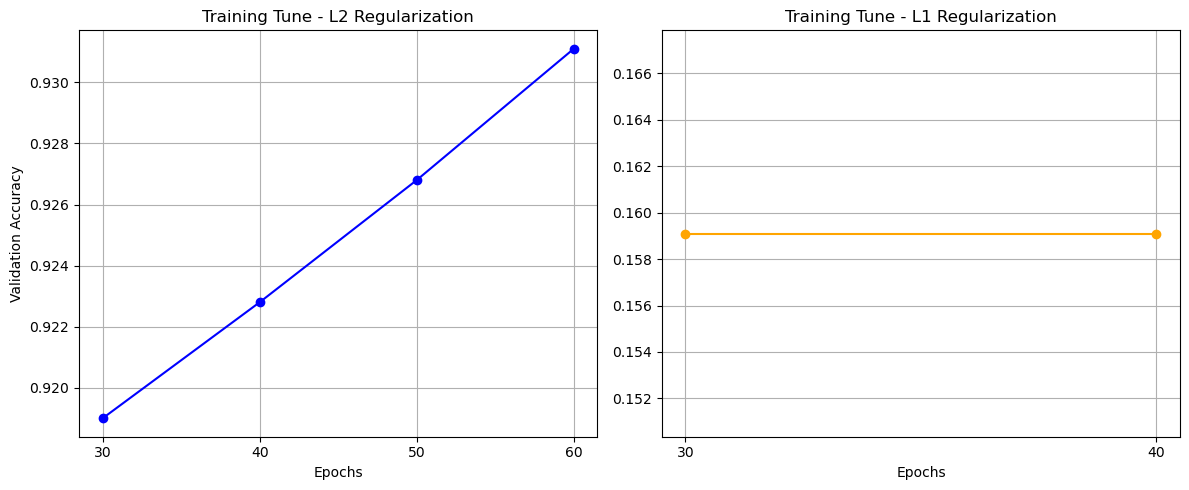

In [13]:
l2_data = {
    "Epochs": [30, 40, 50, 60],
    "Validation Accuracy": [0.9190, 0.9228, 0.9268, 0.9311]
}

l1_data = {
    "Epochs": [30, 40],
    "Validation Accuracy": [0.1591, 0.1591]
}
# Plotting the data with x-axis displaying only tested epoch numbers
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# L2 Regularization plot
axes[0].plot(l2_data["Epochs"], l2_data["Validation Accuracy"], marker='o', label="L2", color='blue')
axes[0].set_title("Training Tune - L2 Regularization")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_xticks(l2_data["Epochs"])  # Set x-axis ticks to tested epochs
axes[0].grid(True)

# L1 Regularization plot
axes[1].plot(l1_data["Epochs"], l1_data["Validation Accuracy"], marker='o', label="L1", color='orange')
axes[1].set_title("Training Tune - L1 Regularization")
axes[1].set_xlabel("Epochs")
axes[1].set_xticks(l1_data["Epochs"])  # Set x-axis ticks to tested epochs
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [21]:
input_dim128 = X_train128.shape[1]
output_dim128 = np.unique(y_train128).size
model = MLP(activation='relu', hidden_layers=2, units=[256, 256], input_dim=input_dim128, output_dim=output_dim128, initialization='xavier')

epoch_times['128'] = {}
training_curves5 = {}
test_accuracies5 = {}
for reg in  ['l2','l1']:
    if reg =='l2':
        epochs = 60
    else:
        epochs = 30
        
    losses, epoch_times['128'][reg] = model.fit_with_time(X_train128, y_train128, 0.001, epochs, batch_size, reg=reg, lambda_=0.1)
    training_curves5[reg] = losses
    y_pred = model.predict_class(X_test128)
    accuracy = evaluate_acc(y_test128.flatten(), y_pred)
    test_accuracies5[reg] = accuracy
    print(f"Test accuracy of model with {reg} regularization, 128*128 data: {accuracy:.4f}")

Epoch 0 done
Epoch 10 done
Epoch 20 done
Epoch 30 done
Epoch 40 done
Epoch 50 done
Test accuracy of model with l2 regularization, 128*128 data: 0.7249
Epoch 0 done
Epoch 10 done
Epoch 20 done
Test accuracy of model with l1 regularization, 128*128 data: 0.1848


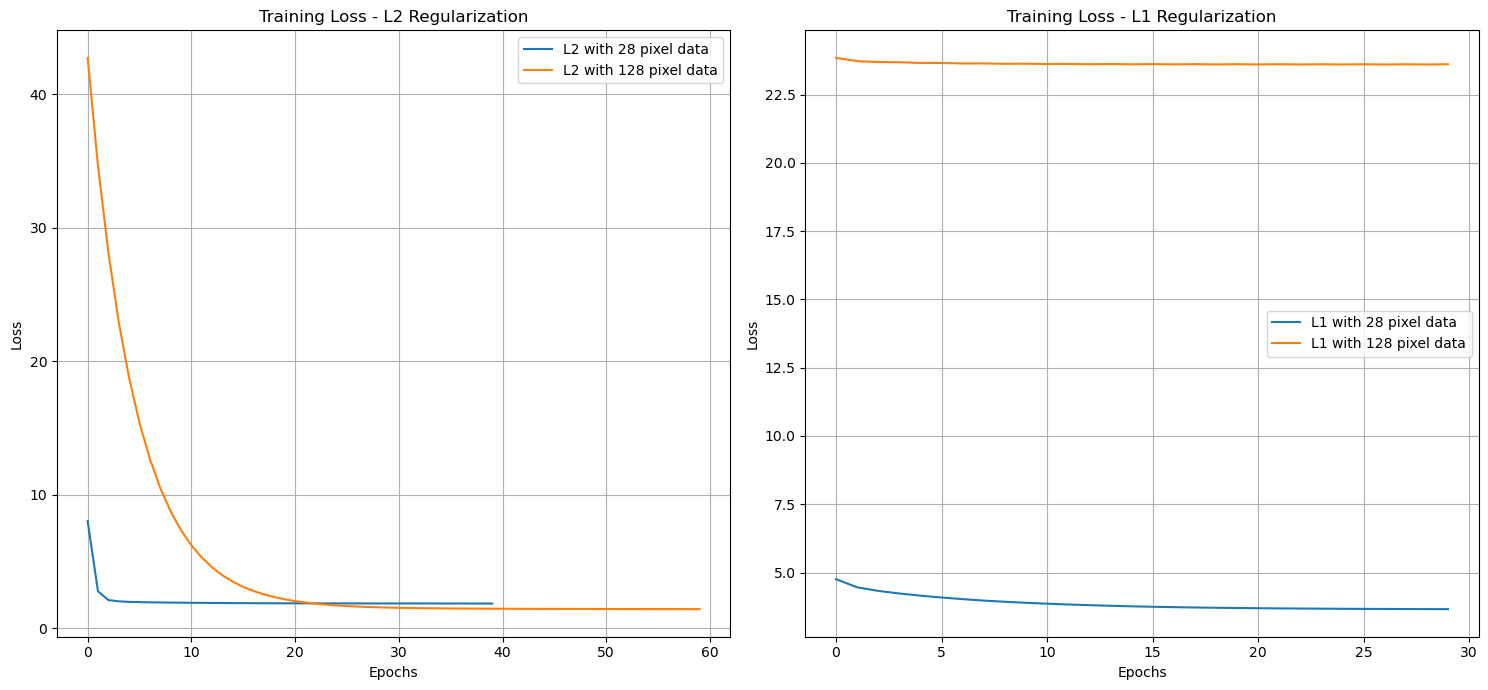

In [22]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
regularizations = ['l2', 'l1']
titles = ['Training Loss - L2 Regularization', 'Training Loss - L1 Regularization']

# Use a loop to plot each regularization type
for i, reg in enumerate(regularizations):
    axes[i].plot(training_curves4[reg], label=f'{reg.upper()} with 28 pixel data')
    axes[i].plot(training_curves5[reg], label=f'{reg.upper()} with 128 pixel data')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].grid()
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

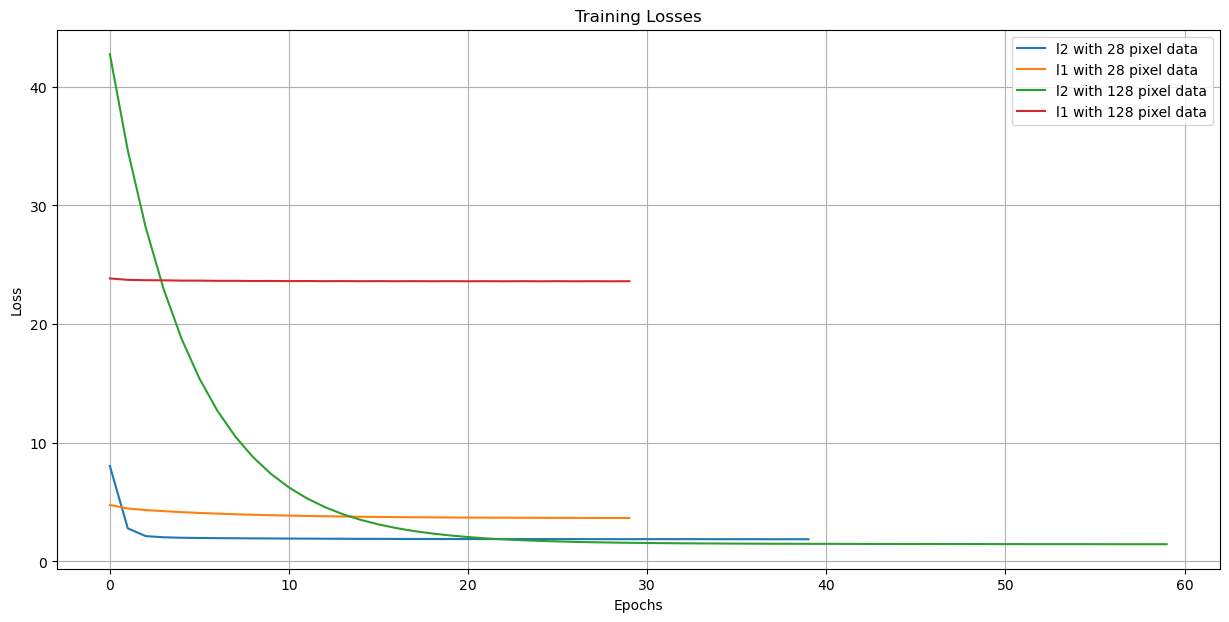

In [23]:
plt.figure(figsize=(15,7))
for reg, losses in training_curves4.items():
    plt.plot(losses, label=f'{reg} with 28 pixel data')
for reg, losses in training_curves5.items():
    plt.plot(losses, label=f'{reg} with 128 pixel data')
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

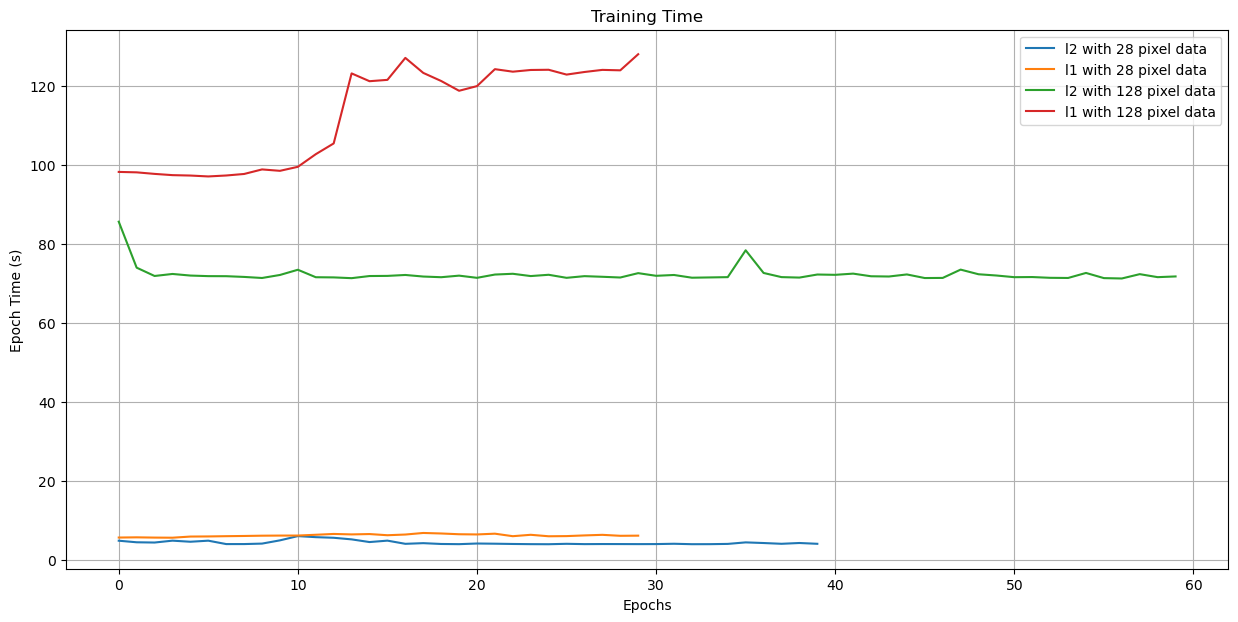

In [24]:
plt.figure(figsize=(15,7))
for reg, time in epoch_times['28'].items():
    plt.plot(time, label=f'{reg} with 28 pixel data')
for reg, time in epoch_times['128'].items():
    plt.plot(time, label=f'{reg} with 128 pixel data')
plt.title('Training Time')
plt.xlabel('Epochs')
plt.ylabel('Epoch Time (s)')
plt.grid()
plt.legend()
plt.show()

## 6. CNN with 2 convolutional layer

In [66]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SimpleCNN, self).__init__()

        # Layer 1: Convolution + BatchNorm + ReLU
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        # Layer 2: Convolution + BatchNorm + ReLU
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # Placeholder for fully connected layers; dimensions will be determined later
        self.fc1 = nn.Linear(1, 1)  # Dummy initialization; will be overwritten in `_initialize_fc`

        # Output layer
        self.fc2 = nn.Linear(256, num_classes)

        # Apply Xavier initialization to layers
        self.apply(self._initialize_weights)

    def _initialize_fc(self, x):
        """Initialize the fully connected layer based on the input dimensions."""
        flattened_size = x.view(x.size(0), -1).size(1)
        self.fc1 = nn.Linear(flattened_size, 256).to(x.device)  # Move to the same device as x
        self._initialize_weights(self.fc1)  # Initialize weights

    def forward(self, x):
        # Pass through convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)

        # Flatten the output and dynamically initialize fc1 if necessary
        if isinstance(self.fc1, nn.Linear) and self.fc1.in_features == 1:
            self._initialize_fc(x)
        x = x.view(x.size(0), -1)  # Flatten before fully connected layer

        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Apply Xavier initialization
            if m.bias is not None:
                nn.init.zeros_(m.bias)  # Initialize biases to zero

In [70]:
# Instantiate the model
modelCNN = SimpleCNN(in_channels=n_channels, num_classes=n_classes)
modelCNN(torch.randn(1, n_channels, 28, 28))  # Dummy forward pass to initialize fc1

# Load the model's state dict
model_path = "simpleCNN_best_model.pth"
modelCNN.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

<All keys matched successfully>

In [ ]:
# evaluation

def test(model, split, size=28, type='CNN'):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = None
    if size == 28:
        data_loader = train_loader_at_eval if split == 'train' else test_loader
    elif size == 128:
        data_loader = train_loader_at_eval128 if split == 'train' else test_loader128
    
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            if type == 'ResNet':
                if inputs.size(1) == 1:  
                    inputs = inputs.repeat(1, 3, 1, 1)  # repeat along the channel dimension to create 3 channels
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                # Ensure targets has two dimensions
                if targets.dim() == 0:  # Check if targets is scalar (0-d)
                    targets = targets.unsqueeze(0)  # Add batch dimension if scalar
                targets = targets.float().unsqueeze(1)  # Ensure it's of shape [N, 1]

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test(modelCNN,'train')
test(modelCNN,'test')

==> Evaluating ...
train  auc: 0.994  acc:0.911
test  auc: 0.974  acc:0.792


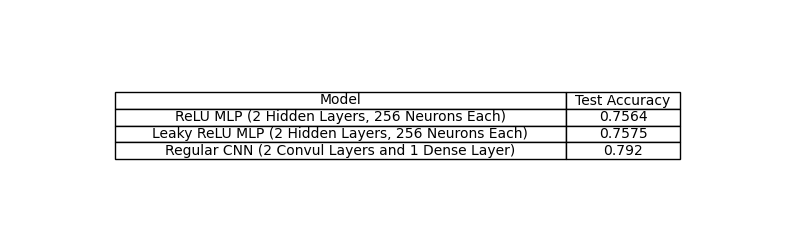

In [15]:
# Data for the table
data = {
    "Model": [
        "ReLU MLP (2 Hidden Layers, 256 Neurons Each)",
        "Leaky ReLU MLP (2 Hidden Layers, 256 Neurons Each)",
        "Regular CNN (2 Convul Layers and 1 Dense Layer)"
    ],
    "Test Accuracy": [0.7564, 0.7575, 0.792]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the table plot
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')  # Turn off the axes

# Add a table
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))

plt.show()


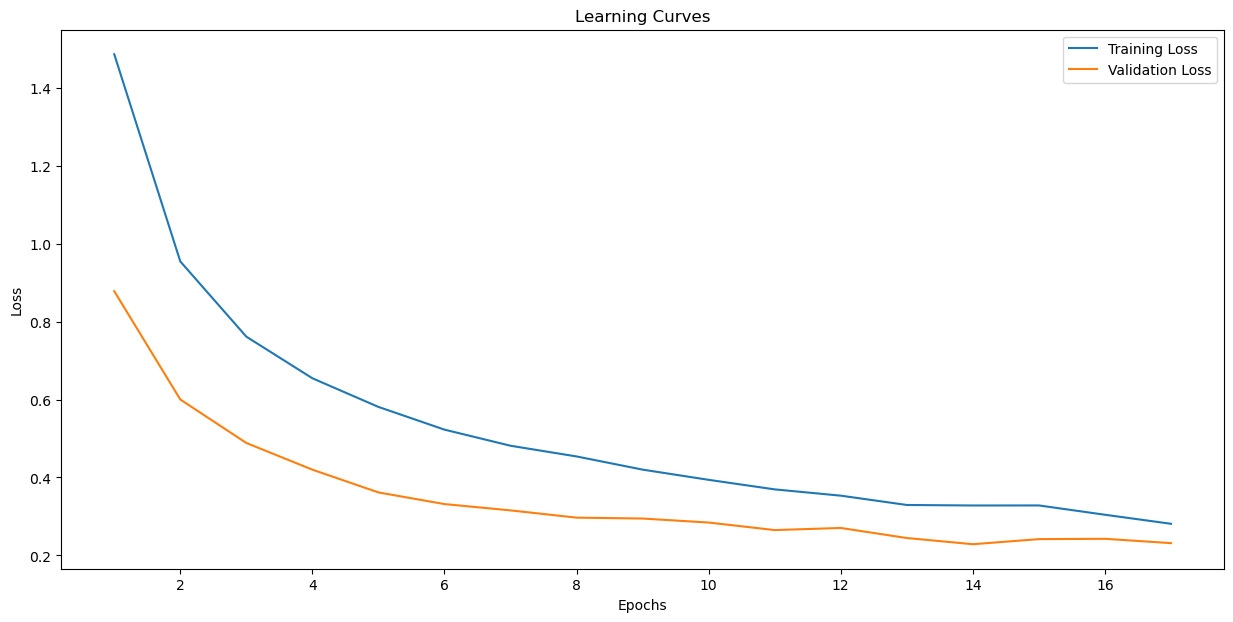

In [ ]:
import re

epochs = []
train_losses = []
val_losses = []

# Open and read the file line by line
with open("gpu-grad-01-75.out", "r") as file:
    for line in file:
        # Match lines for training and validation losses
        train_match = re.search(r"Epoch \[(\d+)/\d+\], Training Loss: ([\d\.]+)", line)
        val_match = re.search(r"Epoch \[(\d+)/\d+\], Validation Loss: ([\d\.]+)", line)

        # Extract training loss
        if train_match:
            epoch = int(train_match.group(1))
            train_loss = float(train_match.group(2))
            epochs.append(epoch)
            train_losses.append(train_loss)

        # Extract validation loss
        if val_match:
            val_loss = float(val_match.group(2))
            val_losses.append(val_loss)

# Plot the learning curves
plt.figure(figsize=(15, 7))
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs[:len(val_losses)], val_losses, label="Validation Loss")  # Validation losses might be fewer

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()


## 7. Modified CNN with 128 pixel data

In [15]:
# modified CNN class
class ModifiedCNN(nn.Module): 
    def __init__(self, in_channels, num_classes, conv1_channels=128, conv2_channels=256, 
                 fc_neurons=128, pool_kernel=2, pool_stride=2):
        super(ModifiedCNN, self).__init__()

        # Layer 1: Convolution + BatchNorm + ReLU + Pooling
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, conv1_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv1_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        )

        # Layer 2: Convolution + BatchNorm + ReLU + Pooling
        self.layer2 = nn.Sequential(
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv2_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel, stride=pool_stride)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(1, 1)  # Dummy initialization for flexibility
        self.fc_neurons = fc_neurons
        self.fc2 = nn.Linear(fc_neurons, num_classes)

        # Apply Xavier initialization
        self.apply(self._initialize_weights)

    def _initialize_fc(self, x):
        """Dynamically initialize the fully connected layer based on the input dimensions."""
        flattened_size = x.view(x.size(0), -1).size(1)
        self.fc1 = nn.Linear(flattened_size, self.fc_neurons).to(x.device)
        self._initialize_weights(self.fc1)

    def forward(self, x):
        # Convolutional layers
        x = self.layer1(x)
        x = self.layer2(x)

        # Flatten
        if isinstance(self.fc1, nn.Linear) and self.fc1.in_features == 1:
            self._initialize_fc(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _initialize_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [16]:
# best parameters selected from validation grid
conv1_channels, conv2_channels, fc_neurons, pool_kernel, pool_stride = (64, 256, 512, 3, 3)

modelCNN = ModifiedCNN(
        in_channels=n_channels,
        num_classes=n_classes,
        conv1_channels=conv1_channels,
        conv2_channels=conv2_channels,
        fc_neurons=fc_neurons,
        pool_kernel=pool_kernel,
        pool_stride=pool_stride
    )

modelCNN(torch.randn(1, n_channels, 128, 128))  # Dummy forward pass to initialize fc1

# Load the model's state dict
model_path = "modifiedCNN_best_model.pth"
modelCNN.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

<All keys matched successfully>

In [ ]:
# evaluation
        
print('==> Evaluating ...')
test(modelCNN,'train', size=128)
test(modelCNN,'test', size=128)

==> Evaluating ...


  0%|          | 0/136 [00:00<?, ?it/s]

100%|██████████| 136/136 [05:44<00:00,  2.54s/it]


train  auc: 1.000  acc:0.989


100%|██████████| 70/70 [02:50<00:00,  2.43s/it]

test  auc: 0.991  acc:0.887


In [48]:
# Define the exact line to look for the best parameters section
best_params_line = "Training with params: conv1_channels=64, conv2_channels=256, fc_neurons=512, pool_kernel=3, pool_stride=3"
in_best_params_section = False
start_capturing_losses = False

# Lists to store training loss, validation loss, and epoch count
training_loss = []
validation_loss = []
num_epochs = 0
epochs = []

# Open and read the file line by line
with open("gpu-grad-01-138.out", "r") as file:
    for line in file:
        # Check if we are at the start of the best parameters section
        if line.strip() == best_params_line:
            in_best_params_section = True
            print("Found best params section start:", line.strip())  # Debug statement
            continue

        # If we're in the best parameters section, process lines to capture losses
        if in_best_params_section:
            # Ignore initial separator lines and start capturing after the first epoch line
            if line.strip() == "=================================================" and not start_capturing_losses:
                continue  # Skip this separator line at the beginning of the section

            # Once we pass the initial separator, start capturing losses
            start_capturing_losses = True
            # Capture training loss
            train_match = re.search(r'Training Loss:\s*([\d.]+)', line)
            if train_match:
                training_loss.append(float(train_match.group(1)))
                num_epochs += 1
                epochs.append(num_epochs)
                print("Captured Training Loss:", train_match.group(1))  # Debug statement

            # Capture validation loss
            val_match = re.search(r'Validation Loss:\s*([\d.]+)', line)
            if val_match:
                validation_loss.append(float(val_match.group(1)))
                print("Captured Validation Loss:", val_match.group(1))  # Debug statement

            # Stop capturing when we hit an end marker after losses have been recorded
            if ("Early stopping" in line or "=================================================" in line) and start_capturing_losses:
                print("End of best params section.")  # Debug statement
                in_best_params_section = False  # Stop capturing after this configuration
                break

Found best params section start: Training with params: conv1_channels=64, conv2_channels=256, fc_neurons=512, pool_kernel=3, pool_stride=3
Captured Training Loss: 0.3667
Captured Validation Loss: 0.1134
Captured Training Loss: 0.1689
Captured Validation Loss: 0.0743
Captured Training Loss: 0.1058
Captured Validation Loss: 0.1301
Captured Training Loss: 0.1319
Captured Validation Loss: 0.0563
Captured Training Loss: 0.0663
Captured Validation Loss: 0.0724
Captured Training Loss: 0.0788
Captured Validation Loss: 0.1114
Captured Training Loss: 0.0971
Captured Validation Loss: 0.0862
End of best params section.


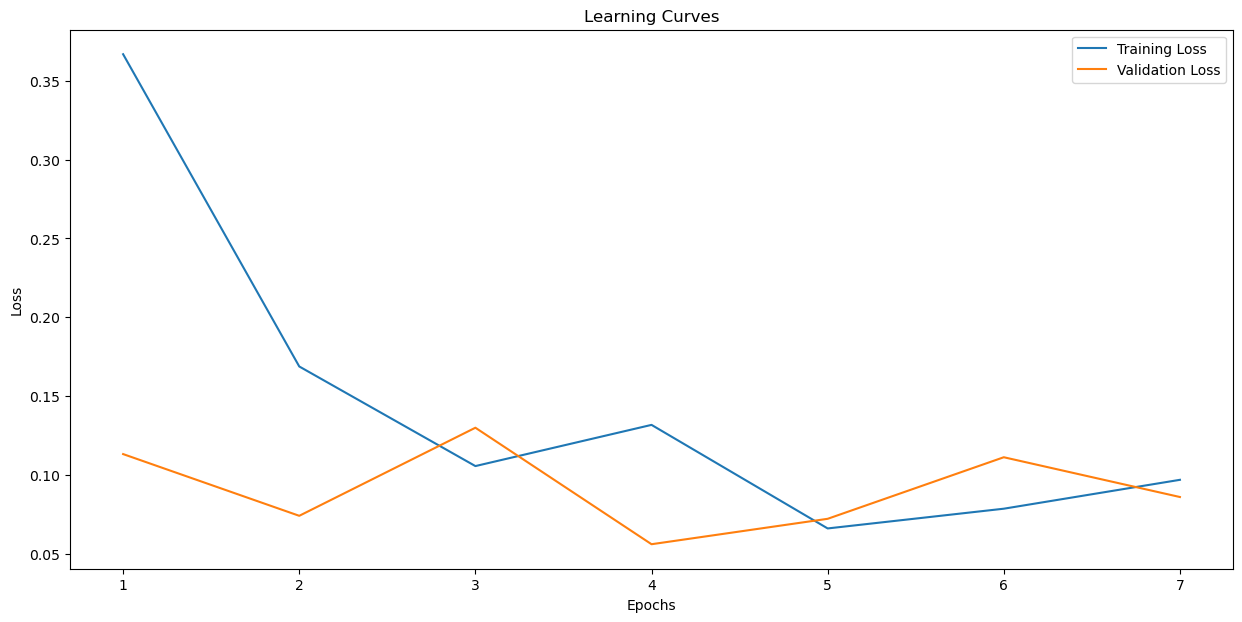

In [53]:
# Plot the learning curves
plt.figure(figsize=(15, 7))
plt.plot(epochs, training_loss, label="Training Loss")
plt.plot(epochs, validation_loss, label="Validation Loss")  # Validation losses might be fewer

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()

## 8. Pretained Model (Resnet) with Removed Dense Layers

In [29]:
class CustomResNet(nn.Module):
    def __init__(self, resnet, num_classes, fc_layers_config):
        super(CustomResNet, self).__init__()
        self.resnet_features = resnet
        self.fc_layers_config = fc_layers_config
        self.num_classes = num_classes

        # Build custom fully connected layers
        fc_layers = []
        in_features = 2048  # Output features from ResNet's avgpool layer
        for neurons in self.fc_layers_config:
            fc_layers.append(nn.Linear(in_features, neurons))
            fc_layers.append(nn.ReLU())
            in_features = neurons
        fc_layers.append(nn.Linear(in_features, self.num_classes))
        self.fc_layers = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.resnet_features(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [32]:
# load trained model back to pc
resnet = torchvision.models.resnet101(pretrained=False)
resnet.avgpool = nn.AdaptiveAvgPool2d((1, 1))
resnet.fc = nn.Identity()

modelResnet = CustomResNet(resnet=resnet, num_classes=n_classes, fc_layers_config=[4096, 4096, 1000, 1000])

model_path = "ResNet_best_model.pth"
modelResnet.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))

modelResnet.to(torch.device("cpu"))

CustomResNet(
  (resnet_features): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [ ]:
print('==> Evaluating ...')
test(modelResnet,'train', size=128, type='ResNet')
test(modelResnet,'test', size=128, type='ResNet')

==> Evaluating ...


100%|██████████| 136/136 [16:47<00:00,  7.41s/it]


train  auc: 0.993  acc:0.912


100%|██████████| 70/70 [10:49<00:00,  9.28s/it]

test  auc: 0.985  acc:0.844


In [ ]:
# Define the exact line to look for the best parameters section
best_params_line = "Training with FC layers configuration: [4096, 4096, 1000, 1000]"
in_best_params_section = False
start_capturing_losses = False

# Lists to store training loss, validation loss, and epoch count
training_loss = []
validation_loss = []
num_epochs = 0
epochs = []

# Open and read the file line by line
with open("gpu-grad-01-199.out", "r") as file:
    for line in file:
        # Check if we are at the start of the best parameters section
        if line.strip() == best_params_line:
            in_best_params_section = True
            print("Found best params section start:", line.strip())  # Debug statement
            continue

        # If we're in the best parameters section, process lines to capture losses
        if in_best_params_section:
            # Ignore initial separator lines and start capturing after the first epoch line
            if line.strip() == "=================================================" and not start_capturing_losses:
                continue  # Skip this separator line at the beginning of the section

            # Once we pass the initial separator, start capturing losses
            start_capturing_losses = True
            # Capture training loss
            train_match = re.search(r'Training Loss:\s*([\d.]+)', line)
            if train_match:
                training_loss.append(float(train_match.group(1)))
                num_epochs += 1
                epochs.append(num_epochs)
                print("Captured Training Loss:", train_match.group(1))  # Debug statement

            # Capture validation loss
            val_match = re.search(r'Validation Loss:\s*([\d.]+)', line)
            if val_match:
                validation_loss.append(float(val_match.group(1)))
                print("Captured Validation Loss:", val_match.group(1))  # Debug statement

            # Stop capturing when we hit an end marker after losses have been recorded
            if ("Early stopping" in line or "=================================================" in line) and start_capturing_losses:
                print("End of best params section.")  # Debug statement
                in_best_params_section = False  # Stop capturing after this configuration
                break

Found best params section start: Training with FC layers configuration: [4096, 4096, 1000, 1000]
Captured Training Loss: 0.5733
Captured Validation Loss: 0.4174
Captured Training Loss: 0.3106
Captured Validation Loss: 0.2735
Captured Training Loss: 0.2595
Captured Validation Loss: 0.2142
Captured Training Loss: 0.2263
Captured Validation Loss: 0.2493
Captured Training Loss: 0.2110
Captured Validation Loss: 0.2859
Captured Training Loss: 0.2123
Captured Validation Loss: 0.2058
Captured Training Loss: 0.1729
Captured Validation Loss: 0.2076
Captured Training Loss: 0.1691
Captured Validation Loss: 0.1929
Captured Training Loss: 0.1779
Captured Validation Loss: 0.2194
Captured Training Loss: 0.1528
Captured Validation Loss: 0.1806
Captured Training Loss: 0.1599
Captured Validation Loss: 0.3427
Captured Training Loss: 0.1628
Captured Validation Loss: 0.3897
Captured Training Loss: 0.1339
Captured Validation Loss: 0.3292
End of best params section.


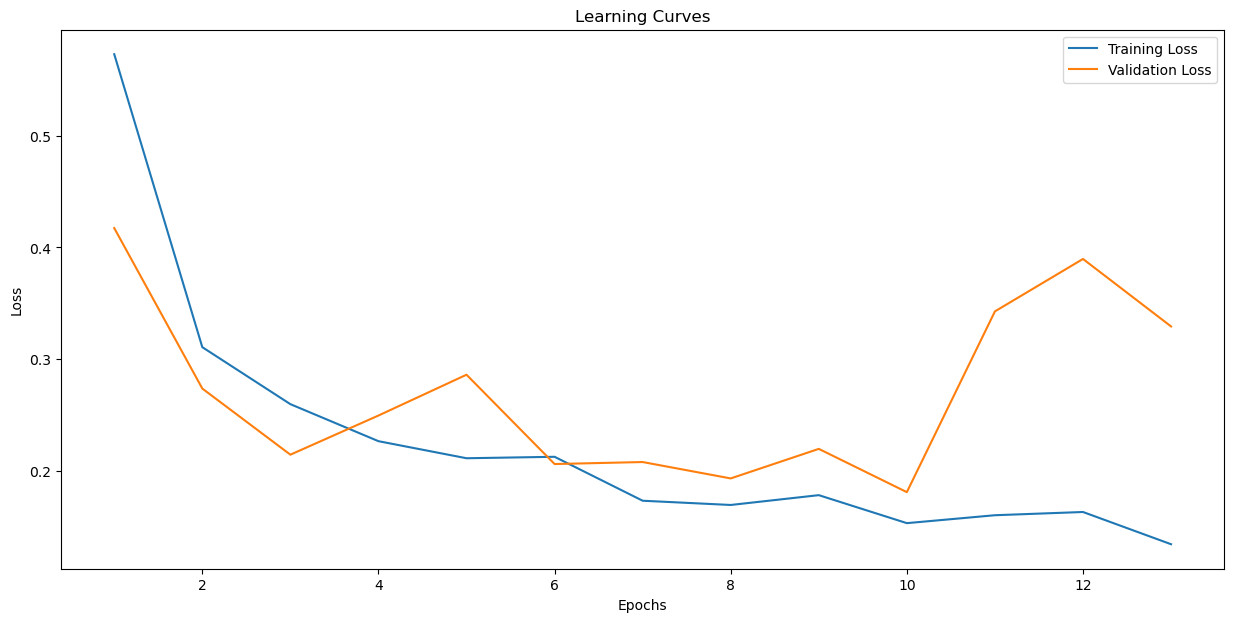

In [38]:
# Plot the learning curves
plt.figure(figsize=(15, 7))
plt.plot(epochs, training_loss, label="Training Loss")
plt.plot(epochs, validation_loss, label="Validation Loss")  # Validation losses might be fewer

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curves")
plt.legend()
plt.show()